# PG Diploma in Machine Learning and AI from IIIT Bangalore | Upgrad

#### Developed by:
##### 1. Vamshi
##### 2. Kunal - Group facilitator




## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- | --- |
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Importing the necessary libraries

import numpy as np
import os
import imageio
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# importing some other libraries which will be needed for model building.
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout


In [5]:
project_folder='/content/drive/MyDrive/Colab Notebooks/gesture recognition project../Project_data/Project_data'

##### Plotting

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=15,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    # MOST IMPORTANT PART HERE - The generator function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=resize(cropped,(self.image_height,self.image_width,3))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Experimenting with Image resolution, number of frames to use and batch_size

 we had expiremented with different image properties like width and height ,but out system keep crashing if we use bigger images so we have fixed the image size as 100*100

 Also by giving the batch size lower, the model will learn the intricate details but system will crash hence we had kepth the batch around 16 to 64

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

## Model 1
### Base Model - This is basically a test model so as to see how the parameters are affecting the training time of the model Batch Size = 64 and No. of Epochs = 2 frame to consider as 20

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


In [8]:
class ModelConv3D1(ModelBuilder):
  def define_model(self, filtersize=(3, 3, 3), dense_neurons=16, dropout=0.25):
    model = Sequential()

    model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(self.num_classes, activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 80*80, 100*100 according the model performance
- we have also kept the number of frames to consider as half of the original video that is 15 frames  becauase as we increase the frame size the model keep crashing again.


##### Sample Cropping

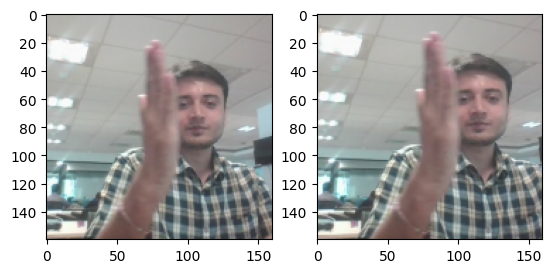

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

In [ ]:
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=80, image_width=80)
conv_3d1.initialize_hyperparams(frames_to_sample=20, batch_size=64, num_epochs=2)
conv_3d1_model = conv_3d1.define_model()
conv_3d1_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 80, 80, 16)    1312      
                                                                 
 activation (Activation)     (None, 20, 80, 80, 16)    0         
                                                                 
 batch_normalization (Batch  (None, 20, 80, 80, 16)    64        
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 40, 40, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 40, 40, 32)    0

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1039525
Epoch 1/2
11/11 [==============================] - ETA: 0s - loss: 1.3413 - categorical_accuracy: 0.4932  
Epoch 1: val_loss improved from inf to 4.10538, saving model to model_init_2024-02-2802_04_56.885417/model-00001-1.34129-0.49321-4.10538-0.23000.h5
11/11 [==============================] - 3491s 346s/step - loss: 1.3413 - categorical_accuracy: 0.4932 - val_loss: 4.1054 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
11/11 [==============================] - ETA: 0s - loss: 0.8353 - categorical_accuracy: 0.6923 
Epoch 2: val_loss improved from 4.10538 to 2.63502, saving model to model_init_2024-02-2802_04_56.885417/model-00002-0.83534-0.69231-2.63502-0.21000.h5
11/11 [==============================] - 468s 43s/step - loss: 0.8353 - categorical_accuracy: 0.6923 - val_loss: 2.6350 - val_categorical_accuracy: 0.2100 - lr: 0.0010


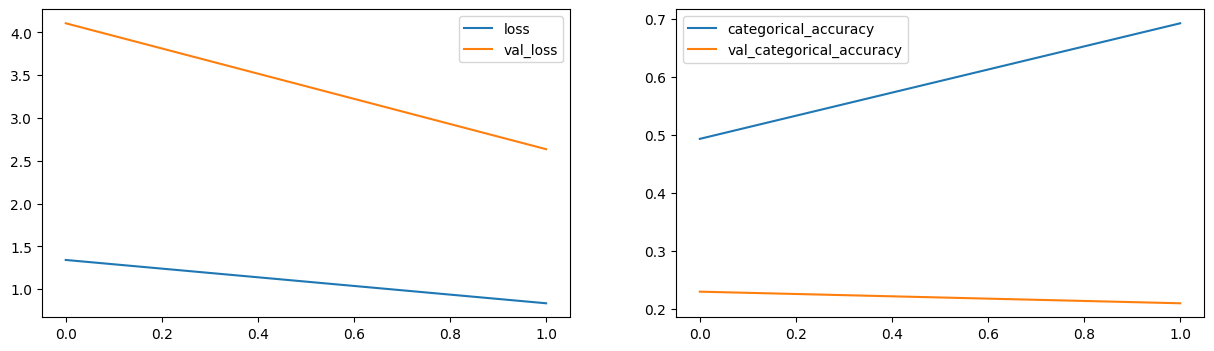

In [ ]:
plot(history_model1)

##### As you can see the Model is clearly overfitting. and not performing well on the validation data as we had to decrease the size of image and frames and increase the batch size and tested for only few epochs due to system performance constraints, hence it is expected to see decline in validation accuracy

## Model 2  
### Adding dropout layers - here we have increase the Batch Size = 128 we might miss the intricate detaisl of the image but helps us training without crashing and No. of Epochs = 15

In [9]:
conv_3d2 = ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=80, image_width=80)
conv_3d2.initialize_hyperparams(frames_to_sample=5, batch_size=128, num_epochs=15)
conv_3d2_model = conv_3d2.define_model()
conv_3d2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 5, 80, 80, 16)     1312      
                                                                 
 activation (Activation)     (None, 5, 80, 80, 16)     0         
                                                                 
 batch_normalization (Batch  (None, 5, 80, 80, 16)     64        
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 40, 40, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 40, 40, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 2, 40, 40, 32)     0

In [12]:

print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=False)

Total Params: 220325
Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 1.5454 - categorical_accuracy: 0.4057  
Epoch 1: val_loss improved from inf to 2.43913, saving model to model_init_2024-02-2813_22_32.027533/model-00001-1.54536-0.40573-2.43913-0.18000.h5
6/6 [==============================] - 360s 69s/step - loss: 1.5454 - categorical_accuracy: 0.4057 - val_loss: 2.4391 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
6/6 [==============================] - ETA: 0s - loss: 0.9435 - categorical_accuracy: 0.6501 
Epoch 2: val_loss improved from 2.43913 to 2.10466, saving model to model_init_2024-02-2813_22_32.027533/model-00002-0.94346-0.65008-2.10466-0.18000.h5
6/6 [==============================] - 110s 19s/step - loss: 0.9435 - categorical_accuracy: 0.6501 - val_loss: 2.1047 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
6/6 [==============================] - ETA: 0s - loss: 0.7626 - categorical_accuracy: 0.7255 
Epoch 3: val_loss improved from

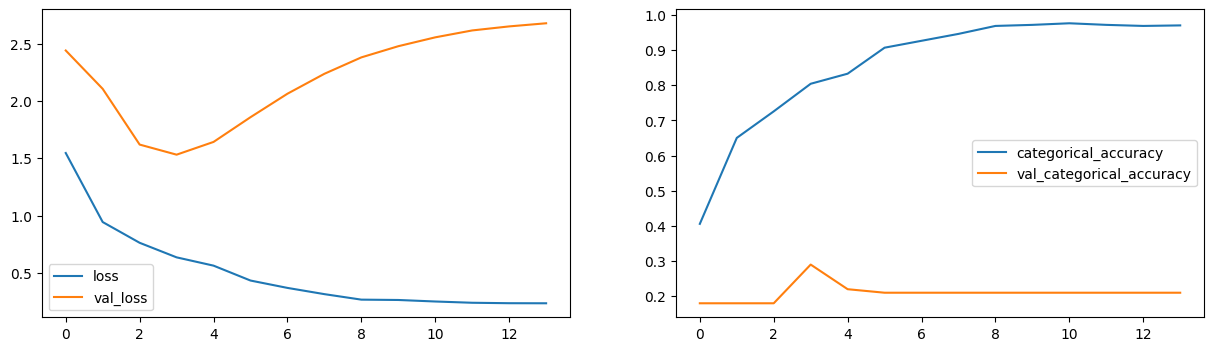

In [13]:
plot(history_model2)

Clearly the model is overfitting as the validation accuracy is not improving.

##### We can see  val_loss did not improve
- Last Epoch stop on 12/15!! good job earlystopping ;)
- Best weights save automatically. The validation accuracy of 20% and training accuracy of 94%. Next we will try to reduce the filter size and image resolution and see if get better results.

## Model 3
### added more layers and reducing the frames to sample and keeping hte dense neurons to 16

In [ ]:
class ModelConv3D2(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=16, dropout=0.25):
        model = Sequential()

        model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Additional Conv3D layers
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))



        # Flatten layer
        model.add(Flatten())

        # Dense layers
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


## checking by increasing the image properties hieght and width and increasing the frames to sample size and reducing the batch size to 64

In [ ]:
conv_3d3 = ModelConv3D2()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=80, image_width=80)
conv_3d3.initialize_hyperparams(frames_to_sample=11, batch_size=128, num_epochs=5)
conv_3d3_model = conv_3d3.define_model()
conv_3d3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 11, 80, 80, 16)    1312      
                                                                 
 activation_6 (Activation)   (None, 11, 80, 80, 16)    0         
                                                                 
 batch_normalization_8 (Bat  (None, 11, 80, 80, 16)    64        
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 5, 40, 40, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 40, 40, 32)     13856     
                                                                 
 activation_7 (Activation)   (None, 5, 40, 40, 32)    

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=False)

Total Params: 173541
Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 1.5348 - categorical_accuracy: 0.3786  
Epoch 1: val_loss improved from inf to 1.72504, saving model to model_init_2024-02-2807_50_00.527008/model-00001-1.53479-0.37858-1.72504-0.24000.h5
6/6 [==============================] - 873s 166s/step - loss: 1.5348 - categorical_accuracy: 0.3786 - val_loss: 1.7250 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.8900 - categorical_accuracy: 0.6727 
Epoch 2: val_loss improved from 1.72504 to 1.51967, saving model to model_init_2024-02-2807_50_00.527008/model-00002-0.89000-0.67270-1.51967-0.25000.h5
6/6 [==============================] - 256s 43s/step - loss: 0.8900 - categorical_accuracy: 0.6727 - val_loss: 1.5197 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.6967 - categorical_accuracy: 0.7783 
Epoch 3: val_loss did not improve

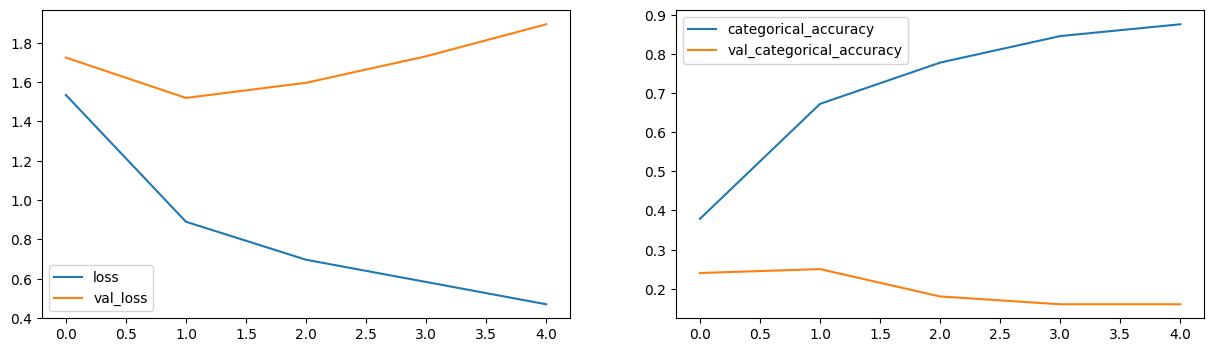

In [ ]:
plot(history_model3)

##### Model has a  best validation accuracy of 20% and training accuracy of 87% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 -
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [ ]:
class ModelConv3D2(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()

        model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Additional Conv3D layers
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())




        # Flatten layer
        model.add(Flatten())

        # Dense layers
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [ ]:
conv_3d4=ModelConv3D2()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=80,image_width=80)
conv_3d4.initialize_hyperparams(frames_to_sample=11,batch_size=128,num_epochs=11)
conv_3d4_model=conv_3d4.define_model()
conv_3d4_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 11, 80, 80, 16)    1312      
                                                                 
 activation_44 (Activation)  (None, 11, 80, 80, 16)    0         
                                                                 
 batch_normalization_46 (Ba  (None, 11, 80, 80, 16)    64        
 tchNormalization)                                               
                                                                 
 max_pooling3d_42 (MaxPooli  (None, 5, 40, 40, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_45 (Conv3D)          (None, 5, 40, 40, 32)     13856     
                                                                 
 activation_45 (Activation)  (None, 5, 40, 40, 32)   

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 702725
Epoch 1/11
6/6 [==============================] - ETA: 0s - loss: 1.6039 - categorical_accuracy: 0.4336  
Epoch 1: val_loss improved from inf to 1.92727, saving model to model_init_2024-02-2812_29_19.548104/model-00001-1.60391-0.43363-1.92727-0.23000.h5
6/6 [==============================] - 500s 80s/step - loss: 1.6039 - categorical_accuracy: 0.4336 - val_loss: 1.9273 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/11
6/6 [==============================] - ETA: 0s - loss: 0.8876 - categorical_accuracy: 0.6508  
Epoch 2: val_loss did not improve from 1.92727
6/6 [==============================] - 490s 82s/step - loss: 0.8876 - categorical_accuracy: 0.6508 - val_loss: 1.9582 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/11
6/6 [==============================] - ETA: 0s - loss: 0.6142 - categorical_accuracy: 0.7828  
Epoch 3: val_loss improved from 1.92727 to 1.64968, saving model to model_init_2024-02-2812_29_19.548104/model-00003-0.61420-0.78281-1

In [ ]:
plot(history_model4)

##  5 Conclusion

##### we have tried to add more layers and experiment with different hyper parameters , but as and when we used to increase the size of image or add more dense neurons the system would crash thus rendering us helpless but we learnt that by changing these hyper parameters increasing the image , frames decreasing the batch size, adding more layers ,adding dropouts model accurcy and validation accuracy would be improved